### Imports iniciais

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold


### Pré-Processamento


In [12]:
df = pd.read_csv("akc-data-latest.csv")

In [13]:

df.rename(columns={"Unnamed: 0": "bZ

In [14]:
#entendendo o formato das colunas do dataframe e a natureza dos elementos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Breeds                       277 non-null    object 
 1   description                  277 non-null    object 
 2   temperament                  276 non-null    object 
 3   popularity                   198 non-null    object 
 4   min_height                   277 non-null    float64
 5   max_height                   277 non-null    float64
 6   min_weight                   275 non-null    float64
 7   max_weight                   275 non-null    float64
 8   min_expectancy               274 non-null    float64
 9   max_expectancy               274 non-null    float64
 10  group                        277 non-null    object 
 11  grooming_frequency_value     270 non-null    float64
 12  grooming_frequency_category  270 non-null    object 
 13  shedding_value      

In [6]:
#dropando colunas não numéricas, exceto a coluna popularidade

object_cols = df.select_dtypes(include=['object']).columns
object_cols = object_cols.drop("popularity", "Breeds")

df = df.drop(columns=object_cols)



In [7]:
final_test = df[
    df['popularity'].isna()
].drop(
    'popularity', axis=1
).dropna()

final_test


,min_height,max_height,min_weight,max_weight,min_expectancy,max_expectancy,grooming_frequency_value,shedding_value,energy_level_value,trainability_value,demeanor_value
5,50.800,63.500,27.215542,45.359237,10.0,12.0,0.2,0.6,0.8,0.6,0.6
10,53.340,68.580,20.411657,31.751466,12.0,15.0,0.4,0.6,0.8,1.0,0.6
14,48.260,55.880,21.772434,31.751466,12.0,15.0,0.4,0.8,1.0,0.2,0.4
18,43.180,50.800,14.514956,20.411657,12.0,15.0,0.4,0.4,0.8,0.8,0.6
23,31.750,39.370,12.246994,15.875733,12.0,12.0,0.4,0.6,0.6,0.2,1.0
25,43.180,52.070,16.782918,29.937096,12.0,15.0,0.4,0.8,0.6,0.6,0.4
30,55.880,66.040,24.947580,29.483504,10.0,12.0,0.4,0.8,0.8,0.8,0.4
44,49.022,55.118,16.782918,27.215542,12.0,15.0,0.2,0.4,0.6,0.8,0.6
45,25.400,30.480,2.494758,4.082331,12.0,14.0,0.6,0.2,0.4,0.6,0.8
53,53.340,68.580,24.947580,40.823313,10.0,14.0,0.2,0.4,0.8,0.8,0.6


In [8]:
df.isna().sum()


popularity                  79
min_height                   0
max_height                   0
min_weight                   2
max_weight                   2
min_expectancy               3
max_expectancy               3
grooming_frequency_value     7
shedding_value              20
energy_level_value           6
trainability_value          24
demeanor_value              25
dtype: int64

In [9]:
#dropando eleementos NaN do dataframe, como parte do pré-processamento
fit_df = df.dropna()
fit_df

,popularity,min_height,max_height,min_weight,max_weight,min_expectancy,max_expectancy,grooming_frequency_value,shedding_value,energy_level_value,trainability_value,demeanor_value
0,148,22.86,29.21,3.175147,4.535924,12.0,15.0,0.6,0.6,0.6,0.8,1.0
1,113,63.50,68.58,22.679619,27.215542,12.0,15.0,0.8,0.2,0.8,0.2,0.2
2,60,58.42,58.42,22.679619,31.751466,11.0,14.0,0.6,0.4,0.6,1.0,0.8
3,47,60.96,71.12,31.751466,58.967008,10.0,13.0,0.8,0.6,0.8,1.0,0.6
4,58,58.42,63.50,34.019428,38.555351,10.0,14.0,0.6,0.6,0.8,0.4,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...
270,101,38.10,38.10,6.803886,8.164663,12.0,15.0,0.4,0.2,0.6,0.6,0.6
271,65,50.80,60.96,15.875733,31.751466,12.0,15.0,0.4,0.6,1.0,0.6,0.6
272,167,54.61,63.50,20.411657,29.483504,12.0,14.0,0.2,0.6,0.8,0.6,0.6
274,140,25.40,58.42,4.535924,24.947580,13.0,18.0,0.2,0.2,0.8,0.6,0.6


In [10]:
#Transformando elementos da coluna popularidade em numéricos
fit_df['popularity'] = pd.to_numeric(fit_df['popularity'], errors='coerce')


/tmp/ipykernel_24566/2809227959.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fit_df['popularity'] = pd.to_numeric(fit_df['popularity'], errors='coerce')


In [11]:
fit_df.corr(method='spearman')


,popularity,min_height,max_height,min_weight,max_weight,min_expectancy,max_expectancy,grooming_frequency_value,shedding_value,energy_level_value,trainability_value,demeanor_value
popularity,1.000000,0.034997,0.057059,0.042350,-0.002815,0.159458,0.084035,-0.183683,-0.118087,0.063101,-0.256293,-0.258926
min_height,0.034997,1.000000,0.962447,0.895051,0.889543,-0.534413,-0.573412,-0.182569,0.288965,0.263169,-0.059378,-0.220854
max_height,0.057059,0.962447,1.000000,0.851860,0.885349,-0.509103,-0.555447,-0.220257,0.298698,0.299714,-0.035098,-0.240532
min_weight,0.042350,0.895051,0.851860,1.000000,0.954184,-0.570405,-0.642898,-0.105730,0.404850,0.186054,-0.102702,-0.233545
max_weight,-0.002815,0.889543,0.885349,0.954184,1.000000,-0.564492,-0.620781,-0.097342,0.388415,0.204693,-0.036822,-0.227813
min_expectancy,0.159458,-0.534413,-0.509103,-0.570405,-0.564492,1.000000,0.716638,0.007810,-0.266048,-0.009713,0.076681,0.134716
max_expectancy,0.084035,-0.573412,-0.555447,-0.642898,-0.620781,0.716638,1.000000,0.089466,-0.408544,-0.113292,0.107806,0.144732
grooming_frequency_value,-0.183683,-0.182569,-0.220257,-0.105730,-0.097342,0.007810,0.089466,1.000000,-0.008159,-0.169565,0.106788,0.099949
shedding_value,-0.118087,0.288965,0.298698,0.404850,0.388415,-0.266048,-0.408544,-0.008159,1.000000,0.220225,0.086965,-0.092402
energy_level_value,0.063101,0.263169,0.299714,0.186054,0.204693,-0.009713,-0.113292,-0.169565,0.220225,1.000000,0.144454,0.025500


### Divisão entre treino e teste

In [1]:
fit_df

NameError: name 'fit_df' is not defined

In [23]:
X_train, X_test, y_train, y_test = train_test_split(fit_df.drop("Breeds", axis=1), fit_df["Breeds"], test_size=0.25, random_state=42)


KeyError: "['Breeds'] not found in axis"

## Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
# Build a Gaussian Classifier
model = GaussianNB()

# Model training
model.fit(X_train, y_train)

# Predict Output
predicted = model.predict(X_test)


### Avaliação de resultados

In [ ]:
((predicted == y_test).sum())/len(y_test) * 100

95.71428571428572

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test, predicted, average="weighted")

0.9571428571428572

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predicted)

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 2, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 2, 0, 0],
       [0, 0, 0, ..., 0, 2, 0],
       [0, 0, 0, ..., 0, 0, 2]])

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

### Avaliação de resultados

In [ ]:
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)



Accuracy: 0.9571428571428572


In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test, predicted, average="weighted")

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predicted)

### Visualização da Árvore Binária

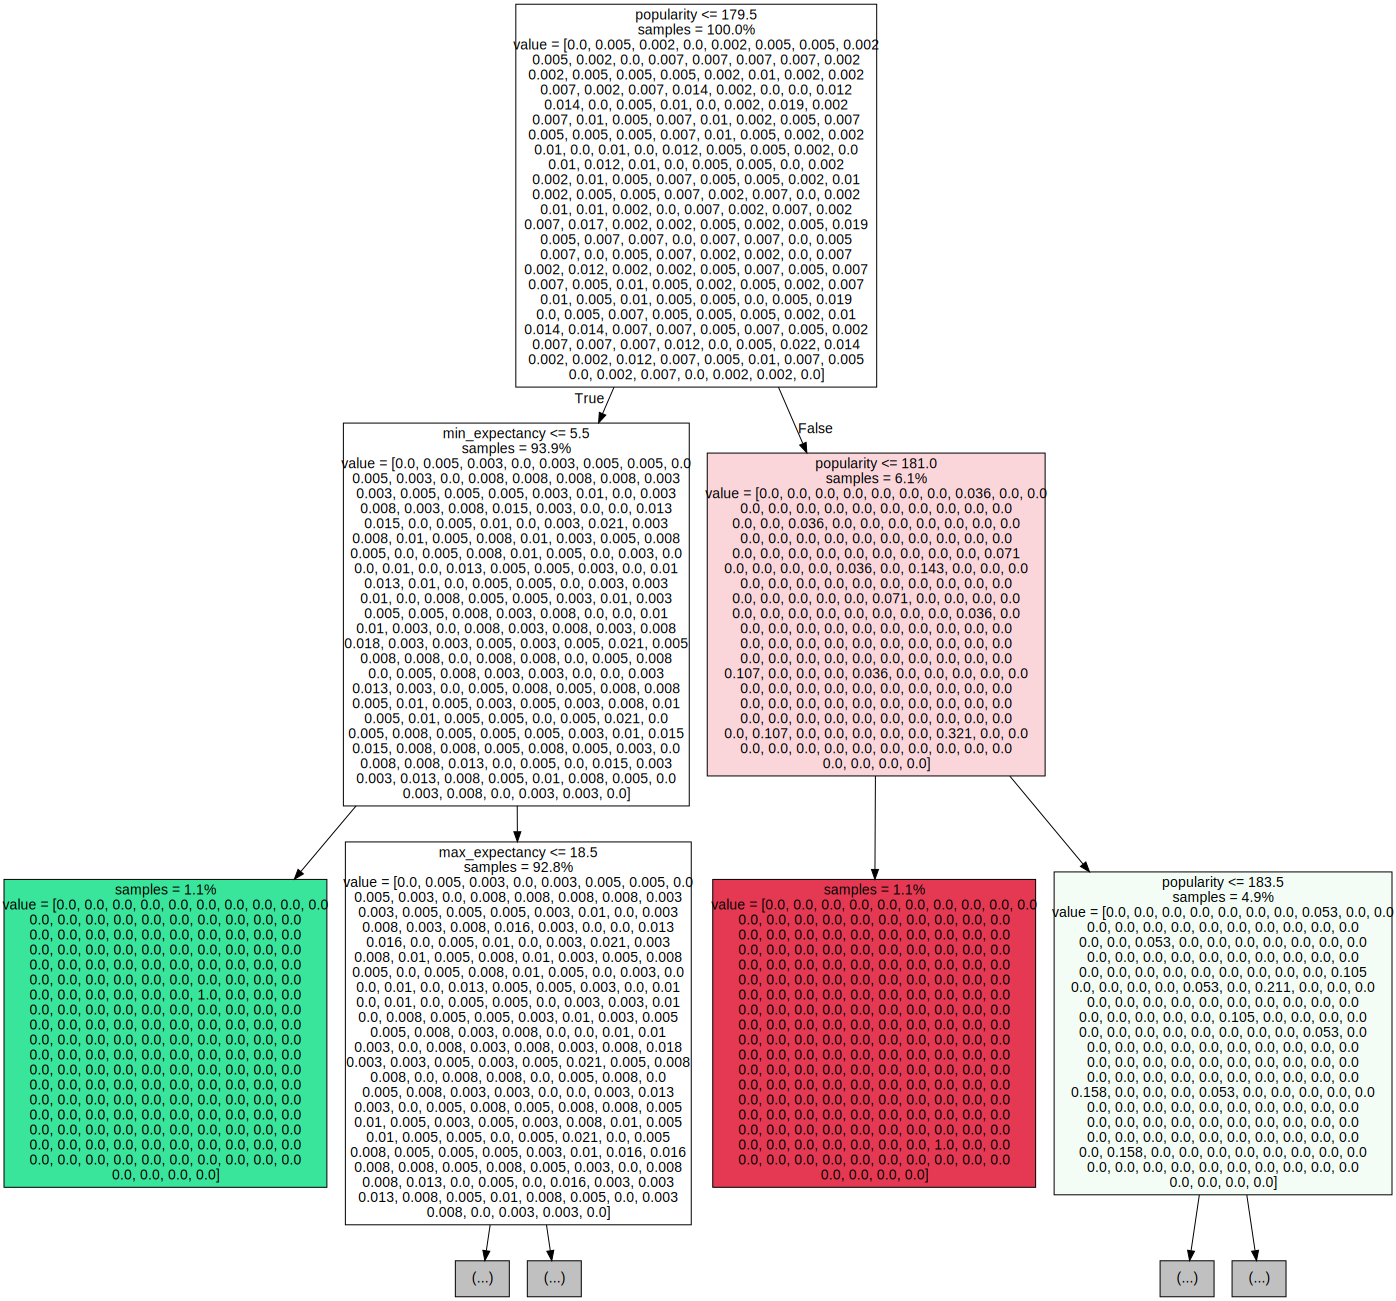

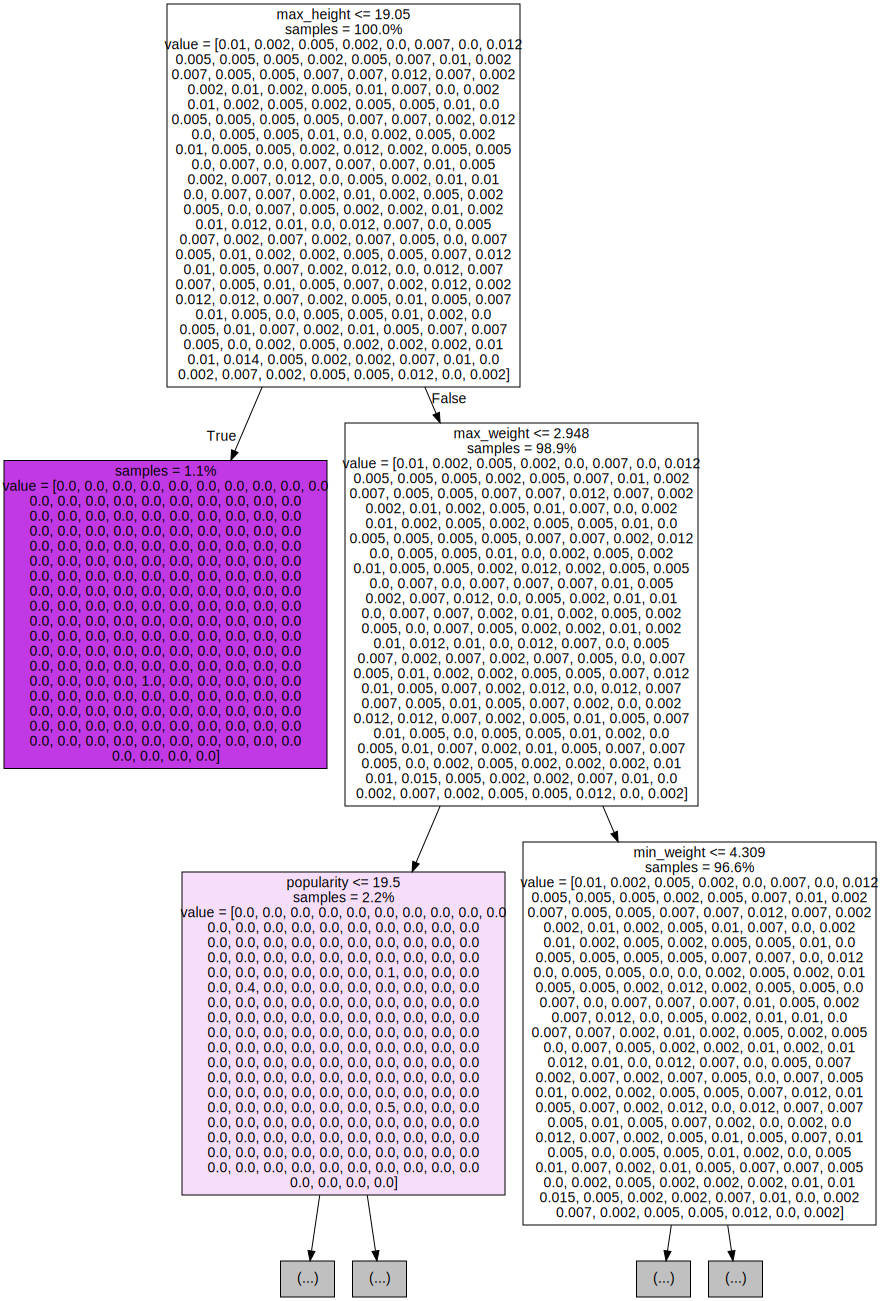

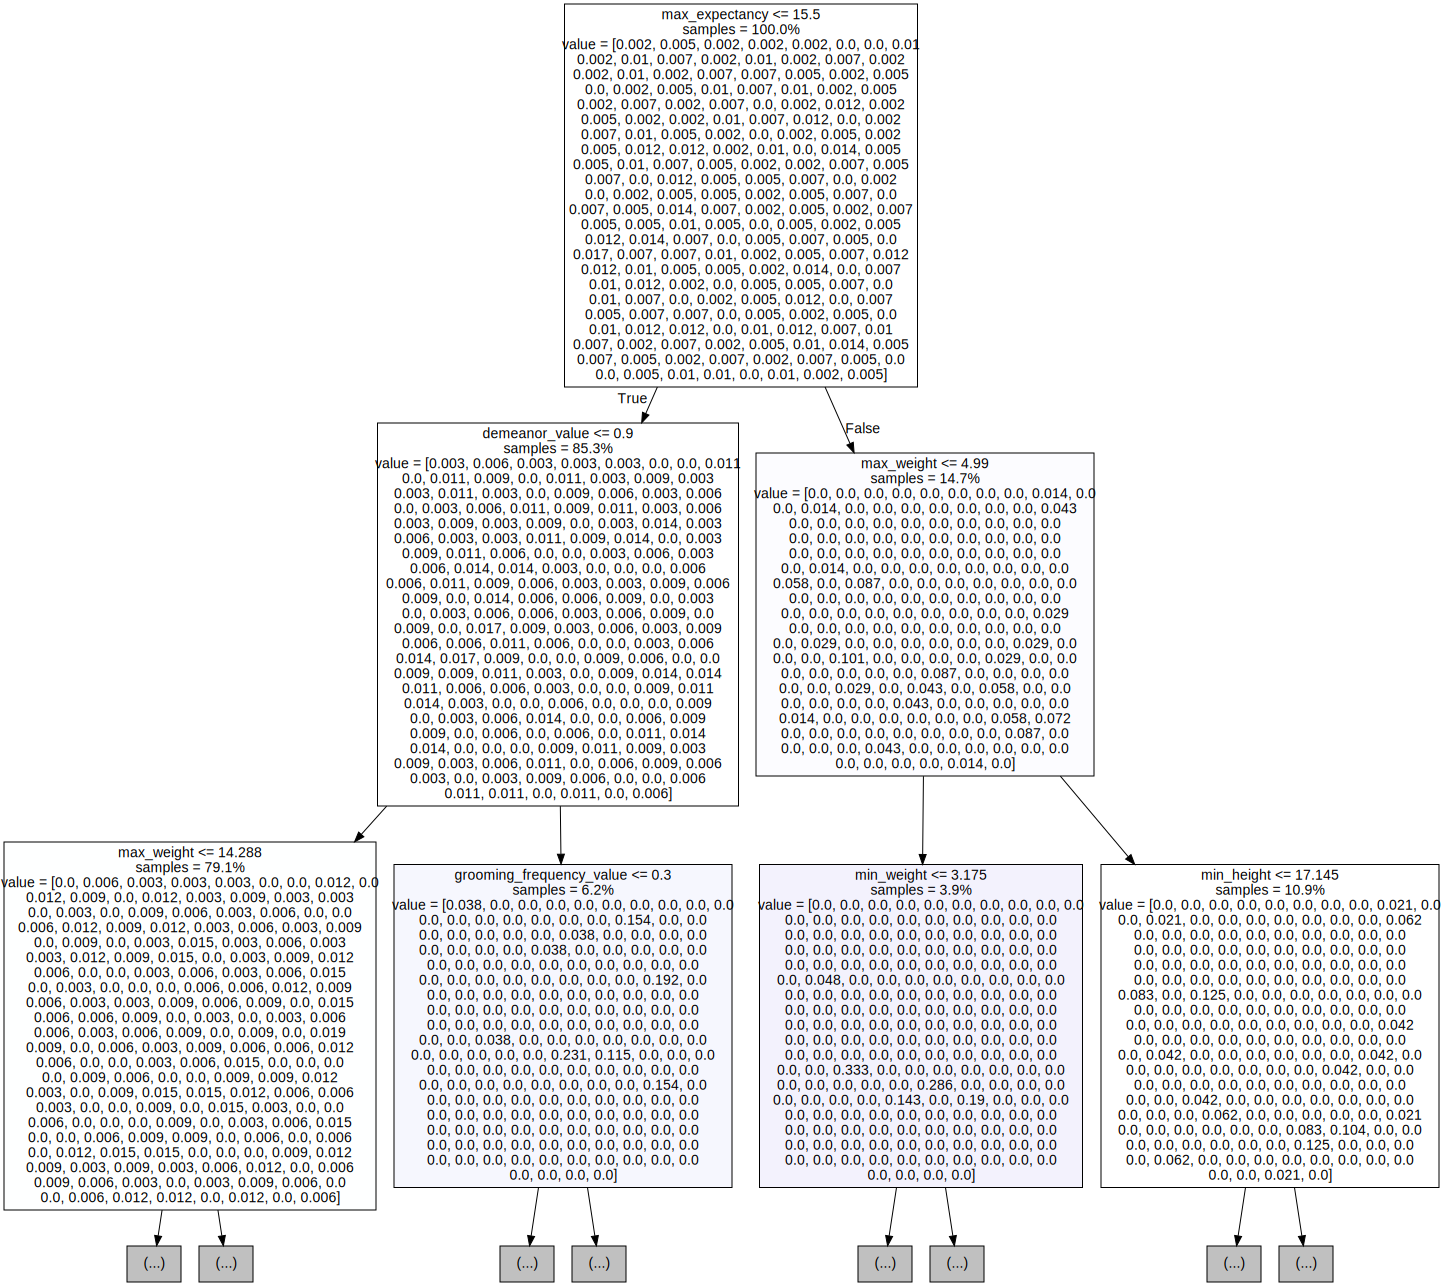

In [ ]:
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,
                               filled=True,
                               max_depth=2,
                               impurity=False,
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)